In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive/AutoModelForSequenceClassification/")


['vocab.txt',
 'model.safetensors',
 'special_tokens_map.json',
 'config.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'labels.pkl',
 'products_cleaned_strategy (1).xlsx',
 'test_model']

In [ ]:
!pip install transformers datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import pandas as pd
import re

# ===============================
# تحميل الإكسل شيت
# ===============================
excel_path = "/content/drive/MyDrive/AutoModelForSequenceClassification/products_cleaned_strategy (1).xlsx"
df = pd.read_excel(excel_path)

# طباعة أسماء الأعمدة لنشوف إيه اللي موجود
print("أعمدة الإكسل شيت:")
print(df.columns.tolist())
print(f"عدد المنتجات: {len(df)}")
print("-" * 50)

# ===============================
# تنظيف النصوص العربية
# ===============================
def normalize_arabic(text):
    """تنظيف وتوحيد النصوص العربية"""
    if pd.isna(text):
        return ""

    text = str(text).strip()
    # توحيد الألف
    text = re.sub(r'[إأآا]', 'ا', text)
    # توحيد التاء المربوطة
    text = re.sub(r'ة', 'ه', text)
    # توحيد الياء
    text = re.sub(r'ى', 'ي', text)
    # توحيد الهمزة
    text = re.sub(r'ئ', 'ء', text)
    # إزالة علامات الترقيم
    text = re.sub(r'[^\w\s]', ' ', text)
    # إزالة المسافات الزائدة
    text = ' '.join(text.split())

    return text.lower()

# ===============================
# البحث في المنتجات
# ===============================
def search_product(search_query, product_column="اسم المنتج", category_column="التصنيف المحاسبي"):
    """البحث عن منتج في الإكسل شيت"""

    # تنظيف كلمة البحث
    normalized_query = normalize_arabic(search_query)
    query_words = normalized_query.split()

    if not query_words:
        return {"found": False, "message": "لم يتم إدخال كلمة بحث صحيحة"}

    results = []

    # البحث في كل منتج
    for index, row in df.iterrows():
        product_name = str(row.get(product_column, ""))
        category = str(row.get(category_column, "غير محدد"))

        if product_name and product_name != "nan":
            normalized_product = normalize_arabic(product_name)

            # التحقق من وجود أي كلمة من البحث في اسم المنتج
            match_found = False
            for query_word in query_words:
                if len(query_word) >= 2 and query_word in normalized_product:
                    match_found = True
                    break

            if match_found:
                confidence = calculate_confidence(search_query, product_name)
                results.append({
                    "اسم_المنتج": product_name,
                    "التصنيف_المحاسبي": category,
                    "درجة_التطابق": calculate_match_score(normalized_query, normalized_product),
                    "الثقة": confidence
                })

    # ترتيب النتائج حسب الثقة أولاً، ثم درجة التطابق
    results.sort(key=lambda x: (x["الثقة"], x["درجة_التطابق"]), reverse=True)

    if results:
        return {
            "found": True,
            "query": search_query,
            "count": len(results),
            "results": results[:10]  # أفضل 10 نتائج
        }
    else:
        return {
            "found": False,
            "query": search_query,
            "message": "لم يتم العثور على منتجات مطابقة"
        }

def calculate_match_score(query, product):
    """حساب درجة التطابق بين البحث والمنتج"""
    query_words = set(query.split())
    product_words = set(product.split())

    if not query_words or not product_words:
        return 0

    # نسبة الكلمات المشتركة
    common_words = query_words.intersection(product_words)
    return len(common_words) / len(query_words)

def calculate_confidence(query, product):
    """حساب الـ Confidence بناءً على عدة عوامل"""

    # تنظيف النصوص
    query_clean = normalize_arabic(query)
    product_clean = normalize_arabic(product)

    query_words = query_clean.split()
    product_words = product_clean.split()

    if not query_words or not product_words:
        return 0.0

    # العامل 1: نسبة الكلمات المشتركة
    query_set = set(query_words)
    product_set = set(product_words)
    common_words = query_set.intersection(product_set)
    word_overlap_ratio = len(common_words) / len(query_set) if query_set else 0

    # العامل 2: التطابق الجزئي للكلمات (substring matching)
    substring_score = 0
    for q_word in query_words:
        if len(q_word) >= 2:  # تجاهل الكلمات القصيرة جداً
            for p_word in product_words:
                if q_word in p_word:
                    # كلما كانت الكلمة أطول، كلما زادت الثقة
                    substring_score += len(q_word) / len(p_word)
                elif p_word in q_word:
                    substring_score += len(p_word) / len(q_word)

    # تطبيع الـ substring score
    substring_score = min(substring_score / len(query_words), 1.0)

    # العامل 3: التطابق الكامل للنص
    if query_clean == product_clean:
        exact_match_bonus = 0.3
    elif query_clean in product_clean or product_clean in query_clean:
        exact_match_bonus = 0.2
    else:
        exact_match_bonus = 0

    # العامل 4: طول الكلمات المطابقة (كلمات أطول = ثقة أكبر)
    length_factor = 0
    if common_words:
        avg_common_length = sum(len(word) for word in common_words) / len(common_words)
        length_factor = min(avg_common_length / 10, 0.1)  # حد أقصى 0.1

    # حساب الـ Confidence النهائي
    confidence = (
        word_overlap_ratio * 0.4 +      # 40% للكلمات المشتركة
        substring_score * 0.3 +         # 30% للتطابق الجزئي
        exact_match_bonus +             # 20-30% للتطابق الكامل
        length_factor                   # 10% لطول الكلمات
    )

    # ضمان أن الثقة بين 0 و 1
    return min(max(confidence, 0.0), 1.0)

# ===============================
# دالة البحث مع فلترة حسب الثقة
# ===============================
def search_with_confidence_filter(product_name, min_confidence=0.3):
    """بحث مع فلترة النتائج حسب مستوى الثقة"""
    result = search_product(product_name)

    if result["found"]:
        # فلترة النتائج حسب الثقة
        filtered_results = [
            item for item in result["results"]
            if item["الثقة"] >= min_confidence
        ]

        if filtered_results:
            result["results"] = filtered_results
            result["count"] = len(filtered_results)
            return result
        else:
            return {
                "found": False,
                "query": product_name,
                "message": f"لا توجد نتائج بثقة أعلى من {min_confidence:.1f}"
            }

    return result

def advanced_search(product_name, min_confidence=0.3):
    """بحث متقدم مع عرض مفصل للنتائج"""
    result = search_with_confidence_filter(product_name, min_confidence)

    print(f"🔍 البحث المتقدم عن: '{product_name}' (حد أدنى للثقة: {min_confidence:.1f})")
    print("=" * 80)

    if result["found"]:
        print(f"✅ تم العثور على {result['count']} منتج(ات) عالي الثقة:")
        print()

        for i, product in enumerate(result["results"], 1):
            # تحديد لون الثقة
            confidence = product['الثقة']
            if confidence >= 0.8:
                confidence_level = "عالية جداً 🔥"
                confidence_color = "🟢"
            elif confidence >= 0.6:
                confidence_level = "عالية ✨"
                confidence_color = "🟢"
            elif confidence >= 0.4:
                confidence_level = "متوسطة ⚡"
                confidence_color = "🟡"
            else:
                confidence_level = "منخفضة ⚠️"
                confidence_color = "🔴"

            print(f"{i:2d}. {confidence_color} المنتج: {product['اسم_المنتج']}")
            print(f"     📊 التصنيف: {product['التصنيف_المحاسبي']}")
            print(f"     📈 درجة التطابق: {product['درجة_التطابق']:.2f}")
            print(f"     🎯 مستوى الثقة: {confidence:.3f} ({confidence_level})")
            print("-" * 60)
    else:
        print(f"❌ {result['message']}")

    print()

# ===============================
# دالة البحث السريع
# ===============================
def quick_search(product_name):
    """بحث سريع وطباعة النتائج"""
    result = search_product(product_name)

    print(f"🔍 البحث عن: '{product_name}'")
    print("=" * 60)

    if result["found"]:
        print(f"✅ تم العثور على {result['count']} منتج(ات):")
        print()

        for i, product in enumerate(result["results"], 1):
            confidence_icon = "🟢" if product['الثقة'] >= 0.7 else "🟡" if product['الثقة'] >= 0.4 else "🔴"

            print(f"{i:2d}. المنتج: {product['اسم_المنتج']}")
            print(f"     التصنيف: {product['التصنيف_المحاسبي']}")
            print(f"     التطابق: {product['درجة_التطابق']:.2f}")
            print(f"     الثقة: {confidence_icon} {product['الثقة']:.3f}")
            print("-" * 40)
    else:
        print(f"❌ {result['message']}")

    print()

# ===============================
# اختبار البحث
# ===============================
def test_search():
    """اختبار البحث على عدة منتجات"""
    test_queries = [
        "حليب",
        "نادك",
        "صابون",
        "منظف",
        "زيت",
        "شامبو",
        "غيث",  # كلمة مش موجودة
        "طماطم"
    ]

    print("🧪 اختبار البحث العادي:")
    print("=" * 80)

    for query in test_queries:
        quick_search(query)

    print("\n🎯 اختبار البحث المتقدم (ثقة عالية):")
    print("=" * 80)

    for query in test_queries[:4]:  # اختبار أول 4 فقط
        advanced_search(query, min_confidence=0.5)

# ===============================
# تشغيل الكود
# ===============================
if __name__ == "__main__":
    # عرض معلومات الملف أولاً
    print("📊 معلومات الملف:")
    print(f"عدد الصفوف: {len(df)}")
    print(f"عدد الأعمدة: {len(df.columns)}")

    # عرض عينة من البيانات
    print("\n📋 عينة من البيانات:")
    print(df.head(3).to_string())
    print("\n" + "=" * 80)

    # تشغيل الاختبارات
    test_search()


أعمدة الإكسل شيت:
['اسم المنتج', 'التصنيف الرئيسي', 'التصنيف الفرعي', 'التصنيف المحاسبي', 'الماركة المصنعة']
عدد المنتجات: 15848
--------------------------------------------------
📊 معلومات الملف:
عدد الصفوف: 15848
عدد الأعمدة: 5

📋 عينة من البيانات:
                        اسم المنتج التصنيف الرئيسي         التصنيف الفرعي                   التصنيف المحاسبي الماركة المصنعة
0  حليب من حليب الأبقار كامل الدسم     أطعمة طازجة  منتجات الألبان والبيض  تكاليف مباشرة - تكلفة بضاعة مباعة           Nadec
1            شوكولاتة بالحليب قطعة     أطعمة طازجة  منتجات الألبان والبيض  تكاليف مباشرة - تكلفة بضاعة مباعة             Kdd
2                   زبادي يوناني ً     أطعمة طازجة  منتجات الألبان والبيض  تكاليف مباشرة - تكلفة بضاعة مباعة         Almarai

🧪 اختبار البحث العادي:
🔍 البحث عن: 'حليب'
✅ تم العثور على 397 منتج(ات):

 1. المنتج: حليب
     التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     التطابق: 1.00
     الثقة: 🟢 1.000
----------------------------------------
 2. المنتج: حليب من حليب الأبق

🚀 بدء تشغيل النظام المحسن...
🧪 اختبار البحث المحسن مع الحفظ:
🔍 البحث المحسن عن: 'حليب' (حد أدنى للثقة: 0.3)
✅ تم العثور على 10 منتج(ات) عالي الثقة:

 1. 🔥 المنتج: حليب
     📊 التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     📈 درجة التطابق: 1.00
     🎯 مستوى الثقة: 1.000 (عالية جداً)
------------------------------------------------------------
 2. 🔥 المنتج: حليب من حليب الأبقار كامل الدسم
     📊 التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     📈 درجة التطابق: 1.00
     🎯 مستوى الثقة: 1.000 (عالية جداً)
------------------------------------------------------------
 3. 🔥 المنتج: حليب نجوم كامل الدسم
     📊 التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     📈 درجة التطابق: 1.00
     🎯 مستوى الثقة: 1.000 (عالية جداً)
------------------------------------------------------------
 4. 🔥 المنتج: حليب الشوكولاتة ً
     📊 التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     📈 درجة التطابق: 1.00
     🎯 مستوى الثقة: 1.000 (عالية جداً)
------------------------------------------------------------
 5. 🔥 المنتج: ح

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ تم حفظ النتائج في ملف JSON: نتائج_البحث.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ تم إنشاء تقرير الأداء: تقرير_الأداء.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ تم إنشاء الرسوم البيانية: search_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

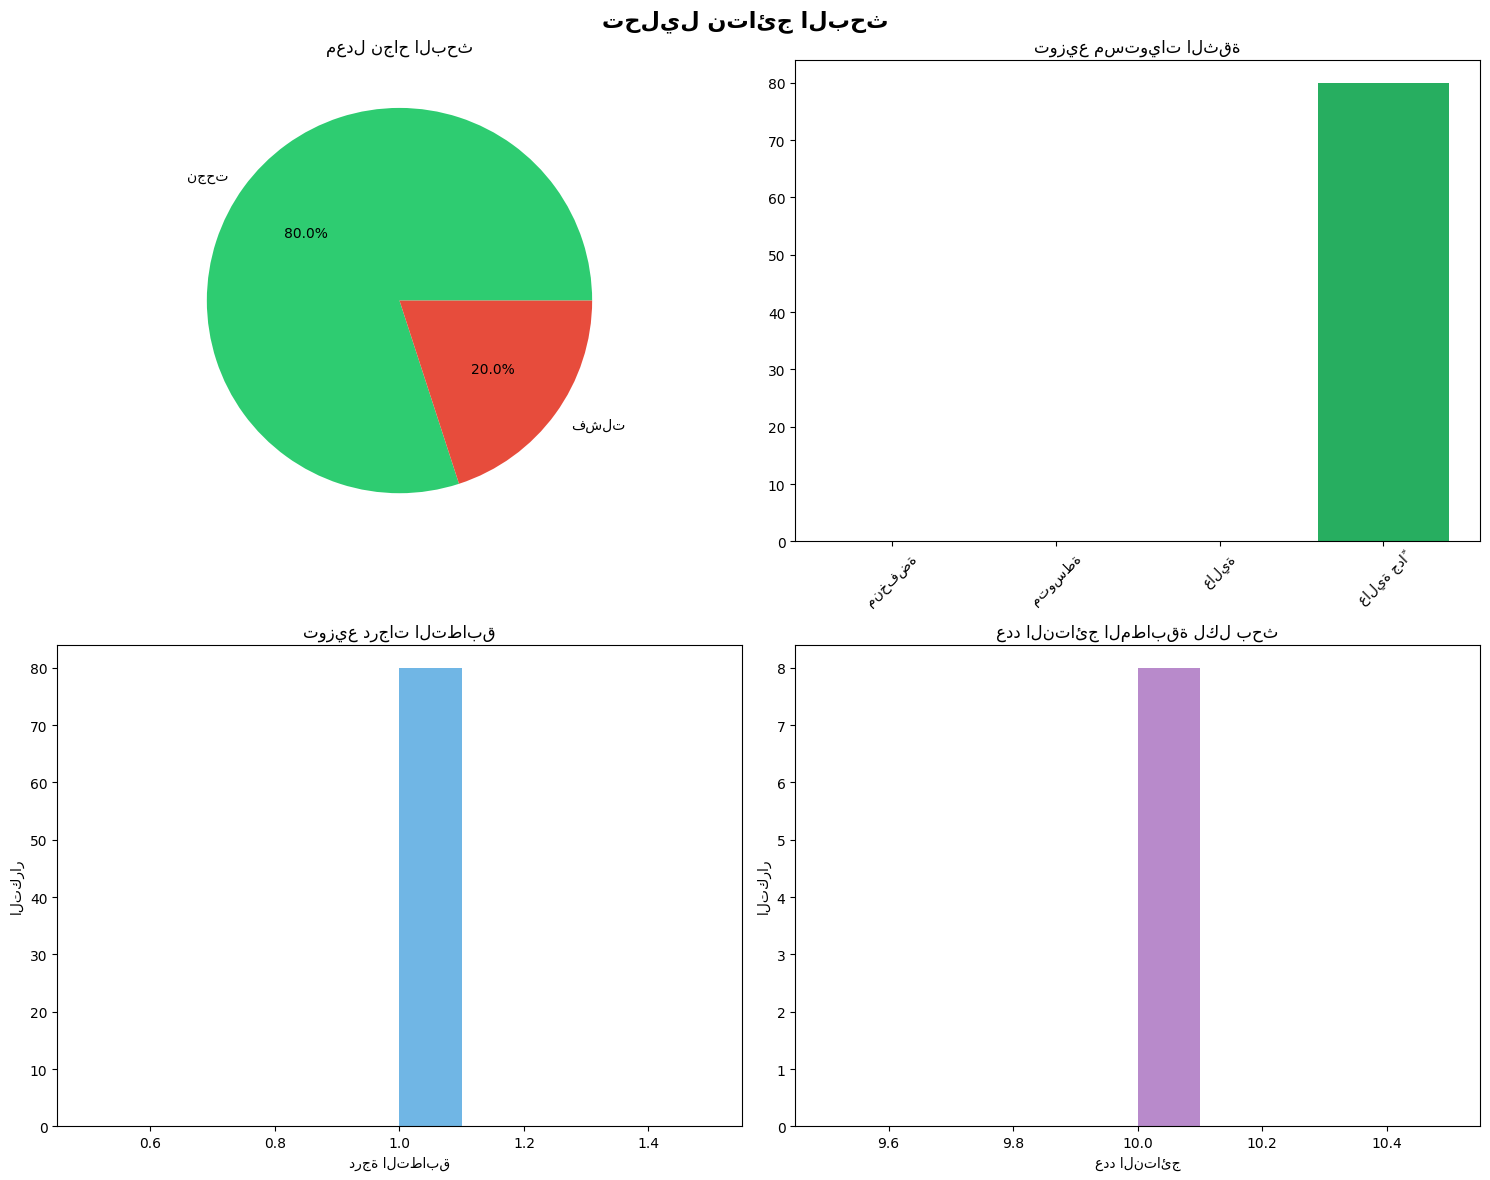

✅ تم حفظ جميع النتائج والتقارير!


In [ ]:


import json
from datetime import datetime
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns



class SearchResultsSaver:
    def __init__(self):
        self.all_results = []
        self.session_stats = {
            'start_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_searches': 0,
            'successful_searches': 0,
            'failed_searches': 0
        }

    def save_search_result(self, query, result):
        """حفظ نتيجة بحث واحدة"""
        search_record = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'query': query,
            'found': result.get('found', False),
            'count': result.get('count', 0),
            'results': result.get('results', [])
        }

        self.all_results.append(search_record)
        self.session_stats['total_searches'] += 1

        if result.get('found', False):
            self.session_stats['successful_searches'] += 1
        else:
            self.session_stats['failed_searches'] += 1

    def save_to_excel(self, filename='search_results.xlsx'):
        """حفظ النتائج في ملف Excel مفصل"""
        if not self.all_results:
            print("❌ لا توجد نتائج للحفظ")
            return


        detailed_results = []

        for search in self.all_results:
            if search['found'] and search['results']:
                for result in search['results']:
                    detailed_results.append({
                        'وقت_البحث': search['timestamp'],
                        'كلمة_البحث': search['query'],
                        'اسم_المنتج_الموجود': result['اسم_المنتج'],
                        'التصنيف_المحاسبي': result['التصنيف_المحاسبي'],
                        'درجة_التطابق': result['درجة_التطابق'],
                        'مستوى_الثقة': result['الثقة'],
                        'تقييم_الثقة': self._get_confidence_level(result['الثقة'])
                    })
            else:
                detailed_results.append({
                    'وقت_البحث': search['timestamp'],
                    'كلمة_البحث': search['query'],
                    'اسم_المنتج_الموجود': 'لم يتم العثور على نتائج',
                    'التصنيف_المحاسبي': '',
                    'درجة_التطابق': 0,
                    'مستوى_الثقة': 0,
                    'تقييم_الثقة': 'غير موجود'
                })

        # إنشاء DataFrame وحفظه
        results_df = pd.DataFrame(detailed_results)

        # إنشاء ملف Excel متعدد الأوراق
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # ورقة النتائج المفصلة
            results_df.to_excel(writer, sheet_name='النتائج_المفصلة', index=False)

            # ورقة الإحصائيات
            stats_df = pd.DataFrame([self.session_stats])
            stats_df.to_excel(writer, sheet_name='إحصائيات_الجلسة', index=False)

            # ورقة تحليل الأداء
            performance_analysis = self._analyze_performance()
            performance_df = pd.DataFrame(performance_analysis)
            performance_df.to_excel(writer, sheet_name='تحليل_الأداء', index=False)

        print(f"✅ تم حفظ النتائج في ملف: {filename}")
        files.download(filename)

    def save_to_json(self, filename='search_results.json'):
        """حفظ النتائج في ملف JSON"""
        if not self.all_results:
            print("❌ لا توجد نتائج للحفظ")
            return

        complete_data = {
            'session_info': self.session_stats,
            'search_results': self.all_results,
            'summary': self._get_summary()
        }

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(complete_data, f, ensure_ascii=False, indent=2)

        print(f"✅ تم حفظ النتائج في ملف JSON: {filename}")
        files.download(filename)

    def create_performance_report(self, filename='performance_report.txt'):
        """إنشاء تقرير أداء مفصل"""
        if not self.all_results:
            print("❌ لا توجد نتائج لإنشاء التقرير")
            return

        report = f"""
📊 تقرير أداء نظام البحث
{'='*50}

📅 معلومات الجلسة:
- وقت البدء: {self.session_stats['start_time']}
- إجمالي عمليات البحث: {self.session_stats['total_searches']}
- عمليات البحث الناجحة: {self.session_stats['successful_searches']}
- عمليات البحث الفاشلة: {self.session_stats['failed_searches']}
- معدل النجاح: {(self.session_stats['successful_searches']/self.session_stats['total_searches']*100):.1f}%

📈 تحليل مستويات الثقة:
"""

        # تحليل مستويات الثقة
        confidence_analysis = self._analyze_confidence_levels()
        for level, count in confidence_analysis.items():
            report += f"- {level}: {count} نتيجة\n"

        report += f"\n🔍 أفضل النتائج (ثقة عالية):\n"

        # أفضل النتائج
        best_results = self._get_best_results()
        for i, result in enumerate(best_results[:5], 1):
            report += f"{i}. '{result['query']}' → '{result['product']}' (ثقة: {result['confidence']:.3f})\n"

        report += f"\n❌ الاستعلامات التي لم تجد نتائج:\n"

        # الاستعلامات الفاشلة
        failed_queries = [search['query'] for search in self.all_results if not search['found']]
        for i, query in enumerate(failed_queries, 1):
            report += f"{i}. '{query}'\n"

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(report)

        print(f"✅ تم إنشاء تقرير الأداء: {filename}")
        files.download(filename)

    def create_visualizations(self):
        """إنشاء رسوم بيانية للنتائج"""
        if not self.all_results:
            print("❌ لا توجد نتائج لإنشاء الرسوم البيانية")
            return

        # إعداد الرسوم البيانية
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('تحليل نتائج البحث', fontsize=16, fontweight='bold')

        # 1. نسبة النجاح
        success_data = [self.session_stats['successful_searches'],
                       self.session_stats['failed_searches']]
        labels = ['نجحت', 'فشلت']
        colors = ['#2ecc71', '#e74c3c']

        axes[0,0].pie(success_data, labels=labels, colors=colors, autopct='%1.1f%%')
        axes[0,0].set_title('معدل نجاح البحث')

        # 2. توزيع مستويات الثقة
        confidence_levels = self._analyze_confidence_levels()
        axes[0,1].bar(confidence_levels.keys(), confidence_levels.values(),
                      color=['#e74c3c', '#f39c12', '#2ecc71', '#27ae60'])
        axes[0,1].set_title('توزيع مستويات الثقة')
        axes[0,1].tick_params(axis='x', rotation=45)

        # 3. توزيع درجات التطابق
        all_matches = []
        for search in self.all_results:
            if search['found']:
                for result in search['results']:
                    all_matches.append(result['درجة_التطابق'])

        if all_matches:
            axes[1,0].hist(all_matches, bins=10, color='#3498db', alpha=0.7)
            axes[1,0].set_title('توزيع درجات التطابق')
            axes[1,0].set_xlabel('درجة التطابق')
            axes[1,0].set_ylabel('التكرار')

        # 4. عدد النتائج لكل بحث
        result_counts = [search['count'] for search in self.all_results if search['found']]
        if result_counts:
            axes[1,1].hist(result_counts, bins=max(10, len(set(result_counts))),
                          color='#9b59b6', alpha=0.7)
            axes[1,1].set_title('عدد النتائج المطابقة لكل بحث')
            axes[1,1].set_xlabel('عدد النتائج')
            axes[1,1].set_ylabel('التكرار')

        plt.tight_layout()
        plt.savefig('search_analysis.png', dpi=300, bbox_inches='tight')
        print("✅ تم إنشاء الرسوم البيانية: search_analysis.png")
        files.download('search_analysis.png')
        plt.show()

    def _get_confidence_level(self, confidence):
        """تحديد مستوى الثقة"""
        if confidence >= 0.8:
            return "عالية جداً"
        elif confidence >= 0.6:
            return "عالية"
        elif confidence >= 0.4:
            return "متوسطة"
        else:
            return "منخفضة"

    def _analyze_confidence_levels(self):
        """تحليل مستويات الثقة"""
        levels = {"منخفضة": 0, "متوسطة": 0, "عالية": 0, "عالية جداً": 0}

        for search in self.all_results:
            if search['found']:
                for result in search['results']:
                    level = self._get_confidence_level(result['الثقة'])
                    levels[level] += 1

        return levels

    def _get_best_results(self):
        """الحصول على أفضل النتائج"""
        best_results = []

        for search in self.all_results:
            if search['found']:
                for result in search['results']:
                    if result['الثقة'] >= 0.7:
                        best_results.append({
                            'query': search['query'],
                            'product': result['اسم_المنتج'],
                            'confidence': result['الثقة']
                        })

        return sorted(best_results, key=lambda x: x['confidence'], reverse=True)

    def _analyze_performance(self):
        """تحليل الأداء"""
        analysis = []

        for search in self.all_results:
            analysis.append({
                'كلمة_البحث': search['query'],
                'نجح_البحث': 'نعم' if search['found'] else 'لا',
                'عدد_النتائج': search['count'],
                'أعلى_ثقة': max([r['الثقة'] for r in search['results']], default=0) if search['found'] else 0,
                'متوسط_الثقة': sum([r['الثقة'] for r in search['results']]) / len(search['results']) if search['found'] and search['results'] else 0
            })

        return analysis

    def _get_summary(self):
        """ملخص النتائج"""
        total_results = sum(search['count'] for search in self.all_results if search['found'])
        avg_confidence = 0

        if total_results > 0:
            total_confidence = 0
            for search in self.all_results:
                if search['found']:
                    for result in search['results']:
                        total_confidence += result['الثقة']
            avg_confidence = total_confidence / total_results

        return {
            'إجمالي_النتائج_الموجودة': total_results,
            'متوسط_الثقة_العام': avg_confidence,
            'معدل_النجاح': self.session_stats['successful_searches'] / self.session_stats['total_searches'] * 100 if self.session_stats['total_searches'] > 0 else 0
        }

# ===============================
# تحديث الدوال الأصلية لتشمل الحفظ
# ===============================

# إنشاء كائن الحفظ
saver = SearchResultsSaver()

def enhanced_search(product_name, min_confidence=0.3, save_result=True):
    """بحث محسن مع حفظ النتائج"""
    result = search_with_confidence_filter(product_name, min_confidence)

    # حفظ النتيجة
    if save_result:
        saver.save_search_result(product_name, result)

    # عرض النتيجة
    print(f"🔍 البحث المحسن عن: '{product_name}' (حد أدنى للثقة: {min_confidence:.1f})")
    print("=" * 80)

    if result["found"]:
        print(f"✅ تم العثور على {result['count']} منتج(ات) عالي الثقة:")
        print()

        for i, product in enumerate(result["results"], 1):
            confidence = product['الثقة']
            confidence_level = saver._get_confidence_level(confidence)
            confidence_icon = "🔥" if confidence >= 0.8 else "✨" if confidence >= 0.6 else "⚡" if confidence >= 0.4 else "⚠️"

            print(f"{i:2d}. {confidence_icon} المنتج: {product['اسم_المنتج']}")
            print(f"     📊 التصنيف: {product['التصنيف_المحاسبي']}")
            print(f"     📈 درجة التطابق: {product['درجة_التطابق']:.2f}")
            print(f"     🎯 مستوى الثقة: {confidence:.3f} ({confidence_level})")
            print("-" * 60)
    else:
        print(f"❌ {result['message']}")

    print()
    return result

def test_and_save():
    """اختبار البحث مع حفظ جميع النتائج"""
    test_queries = [
        "حليب",
        "نادك",
        "صابون",
        "منظف",
        "زيت",
        "شامبو",
        "غيث",
        "طماطم",
        "عصير",
        "ماء"
    ]

    print("🧪 اختبار البحث المحسن مع الحفظ:")
    print("=" * 80)

    for query in test_queries:
        enhanced_search(query, min_confidence=0.3)

    # حفظ النتائج بكل الطرق
    print("\n💾 حفظ النتائج...")
    saver.save_to_excel('نتائج_البحث.xlsx')
    saver.save_to_json('نتائج_البحث.json')
    saver.create_performance_report('تقرير_الأداء.txt')
    saver.create_visualizations()

    print("✅ تم حفظ جميع النتائج والتقارير!")

# دالة سريعة للحفظ فقط
def save_current_results():
    """حفظ النتائج الحالية فقط"""
    saver.save_to_excel('نتائج_البحث_سريع.xlsx')
    saver.create_performance_report('تقرير_سريع.txt')

# ===============================
# لتشغيل الاختبار مع الحفظ
# ===============================

# تشغيل مباشر للحفظ
print("🚀 بدء تشغيل النظام المحسن...")
print("=" * 50)

# تشغيل الاختبار مع الحفظ
test_and_save()

In [ ]:
quick_search("غيث")

🔍 البحث عن: 'غيث'
❌ لم يتم العثور على منتجات مطابقة



In [9]:
quick_search("فريق")

🔍 البحث عن: 'فريق'
✅ تم العثور على 2 منتج(ات):

 1. المنتج: فريق المحاسبين
     التصنيف: مصروفات عمومية - استشارات محاسبية
     التطابق: 1.00
     الثقة: 🟢 1.000
----------------------------------------
 2. المنتج: فارمَرز أورجنز - كبسولات قهوة أفريقيا، أنبوب من 10 كبسولات،
     التصنيف: تكاليف مباشرة - تكلفة بضاعة مباعة
     التطابق: 0.00
     الثقة: 🔴 0.371
----------------------------------------

